In [1]:

NUM_PROC_MAP = 150 # expect 30 min with single process
PUSH_TO_HF = False

DEBUG = True
EPOCHS = 10
HF_USERNAME = None

In [2]:
import os

from dotenv import load_dotenv
load_dotenv()
import datasets
from datasets import DatasetDict
from datasets import load_dataset
import datasets
import torch
import json
from huggingface_hub import HfApi

import numpy as np

from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm
import plotting
import matplotlib.pyplot as plt
import json
import os
import pandas as pd
import torch
import datasets
from datasets import load_dataset
import util



DEBUG = True


In [3]:
from baseline_curricula import validate_training_duration_limitation
from itertools import product
import config 

# validate_training_duration_limitation("loris3/babylm_2024_10m_curriculum", "random.pt")

In [4]:
11026808   / 2358028 

4.676283742177786

In [5]:
from baseline_curricula import validate_training_duration_limitation
from itertools import product
import config 
from util import get_curriculum

data = []
for d in product(config.datasets, config.curricula):
    curriculum = get_curriculum(*d)
    print(d, curriculum)
    data.append((d, torch.cat(curriculum).flatten()))
    



('loris3/babylm_2024_10m_curriculum', 'random.pt') [tensor([462446, 809355, 368322,  ...,  39603, 402942, 413224]), tensor([1043188,   83287,    4986,  ...,  888024,  315089,  485807]), tensor([ 990716, 1173500,  715941,  ...,  540916,  768955,  349777]), tensor([ 999954,  149294,  739773,  ..., 1141682, 1045478,  626108]), tensor([ 359215,  277636, 1035301,  ...,    1674,  291775,  612176]), tensor([411963, 601356, 471672,  ..., 944379, 929044, 494661]), tensor([ 519346, 1125567,  929543,  ...,  416022,   28865,  410770]), tensor([ 862891,  345975, 1090811,  ...,  834544,  307552,  322251]), tensor([1119829,   24267, 1148313,  ...,   53795,  715191,   90101]), tensor([  69351,  642529,  740593,  ..., 1007246,  693065,  674208])]
('loris3/babylm_2024_10m_curriculum', 'source_difficulty.pt') [tensor([  8933, 437545, 471759,  ...,  33991, 224857, 383641]), tensor([156889, 224053, 264396,  ..., 243565,  34977, 399672]), tensor([616349, 589845, 627263,  ..., 662138, 606808, 589816]), tenso

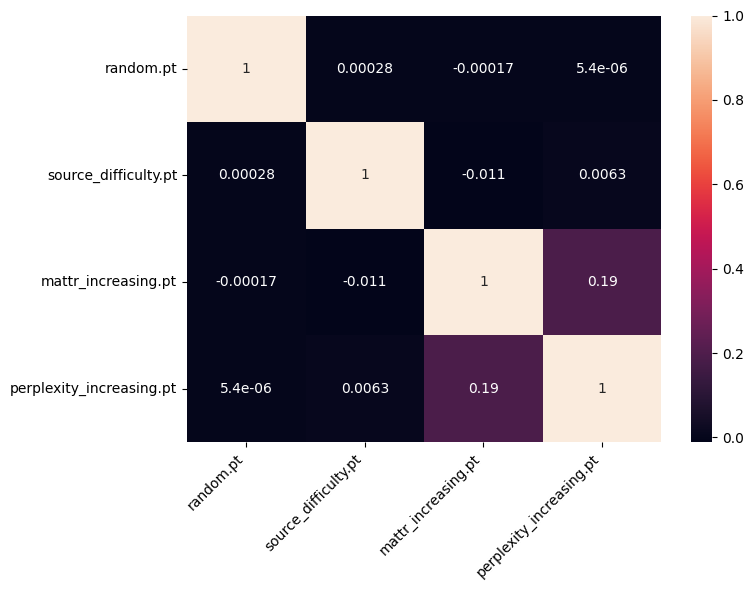

In [6]:
import torch
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

tensors = [item[1] for item in data]
file_names = [item[0][1] for item in data] 


min_length = min(tensor.shape[0] for tensor in tensors)


truncated_tensors = [tensor[:min_length] for tensor in tensors]


corr_matrix = np.zeros((len(tensors), len(tensors)))

for i in range(len(tensors)):
    for j in range(len(tensors)):
        corr, _ = spearmanr(truncated_tensors[i].numpy(), truncated_tensors[j].numpy())
        corr_matrix[i, j] = corr


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, xticklabels=file_names, 
            yticklabels=file_names, cbar=True)

plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()


As in the official [preprocessing repo](https://github.com/babylm/babylm_data_preprocessing), we get the number of words via `line.split()`:

In [7]:
word_count = lambda d: len(d.split())
word_count_dataset = lambda dataset:sum([word_count(d) for d in dataset["text"]])

## New Curriculum based on Influence during learning on randomly shuffled data

In [8]:


from itertools import product

import config

jobs = [(d+"_"+t+"_"+"random", d) for d, t in product(config.datasets, config.model_types)]

In [9]:
jobs

[('loris3/babylm_2024_10m_curriculum_llama_random',
  'loris3/babylm_2024_10m_curriculum')]

In [10]:
from baseline_curricula import upload, split_into_epochs, repeat_for_ten_epochs

In [11]:
##########old
get_order_top_n_pct = lambda top_n_pct, df: torch.stack([torch.tensor(df[checkpoint].sort_values(ascending=False).head(int(len(df)*top_n_pct*0.01)).index.to_numpy()) for checkpoint in influence_cols])


In [12]:
def lognorm_filter(size, **args):
    indices = np.arange(-size, size+1, 1)
    weights = lognorm.pdf(indices+1, **args)
    return weights / np.sum(weights)
dirac_filter = lambda size: np.eye(1, (size*2)+1, size, dtype=float).flatten()

def reweight_df(df, influence_cols, filter_weights):
    scores = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=df[influence_cols].to_numpy()))
    scores.columns = influence_cols
    df_reweighted = df.copy()
    df_reweighted[influence_cols] = scores
    df_reweighted["total"] = df_reweighted[influence_cols].sum(axis=1)
    return df_reweighted

apply_lognorm = lambda df : reweight_df(df, influence_cols, lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5))
apply_dirac = lambda df : reweight_df(df, influence_cols, dirac_filter(len(influence_cols)))

def get_shuffled_bins(df, bin_size=1000, ascending=False):
    torch.manual_seed(42)
    return [torch.tensor(
        np.concat(
            [
                np.random.permutation(bin) for bin in 
                np.array_split(df[checkpoint].sort_values(ascending=ascending).index.to_numpy(), indices_or_sections=len(df) // 1000)
            ]
        )
    )
    for checkpoint in influence_cols]


def get_influence_top_50_twice_cp_shuffled(df): 
    torch.manual_seed(42)
    return [torch.tensor(
        np.random.permutation(
            np.repeat(
                df[checkpoint].sort_values(ascending=False).head(int(len(df)*50*0.01)).index.to_numpy(),2))
            
        ) 
        for checkpoint in influence_cols]

def make_tracin_sandwich(df):
    torch.manual_seed(42)

    chunks = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), len(influence_cols))
    beneficial_chunks = chunks[0:len(chunks)//2]
    harmful_chunks = chunks[len(chunks)//2:]
    beneficial_chunks_start = [beneficial_chunk.repeat(10) for beneficial_chunk in beneficial_chunks]
    harmful_chunks = [harmful_chunk.repeat(5) for harmful_chunk in harmful_chunks]
    beneficial_chunks_end = [beneficial_chunk.repeat(5) for beneficial_chunk in beneficial_chunks]
    influential_examples_sandwich = list(torch.tensor_split(torch.cat([chunk[torch.randperm(len(chunk))] for chunk in beneficial_chunks_start + harmful_chunks + beneficial_chunks_end]), len(influence_cols)))
    return influential_examples_sandwich

functions = {



    "influence_incr_bins_dirac": lambda df: get_shuffled_bins(apply_dirac(df), bin_size=1000, ascending=True),
    "influence_decr_bins_dirac": lambda df: get_shuffled_bins(apply_dirac(df), bin_size=1000, ascending=False),

    "influence_incr_bins_lognorm": lambda df: get_shuffled_bins(apply_lognorm(df), bin_size=1000, ascending=True),
    "influence_decr_bins_lognorm": lambda df: get_shuffled_bins(apply_lognorm(df), bin_size=1000, ascending=False),

    "influence_incr_cp_dirac" : lambda df: [torch.tensor(apply_dirac(df)[checkpoint].sort_values(ascending=True).index.to_numpy()) for checkpoint in influence_cols],
    "influence_decr_cp_dirac" : lambda df: [torch.tensor(apply_dirac(df)[checkpoint].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols],

    "influence_incr_cp_lognorm" : lambda df: [torch.tensor(apply_lognorm(df)[checkpoint].sort_values(ascending=True).index.to_numpy()) for checkpoint in influence_cols],
    "influence_decr_cp_lognorm" : lambda df: [torch.tensor(apply_lognorm(df)[checkpoint].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols],

    "influence_top_50_twice_cp_shuffled" : get_influence_top_50_twice_cp_shuffled,
    "influence_tracin_sandwich" : make_tracin_sandwich

    
}

from baseline_curricula import validate_training_duration_limitation
from itertools import product
import config 

def create_curricula(df, influence_cols, dataset_name, curriculum="random.pt"):
    for name, function in functions.items():
        print(name)
        new_curriculum = function(df)
        print(new_curriculum)
        plotting.plot_per_document_in_order(df[influence_cols],new_curriculum)
        plt.show()
        validate_training_duration_limitation(dataset_name, new_curriculum)

    
   

./influence_mean_normalized/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum_train[0%:100%]_babylm_2024_10m_curriculum_train[0%:100%]


,5750,4600,4604,5755,4025,2300,1150
0,0.678787,0.654035,0.612421,0.614727,0.554808,0.643681,0.644924
1,0.451455,0.360522,0.321535,0.500421,0.293428,0.383101,0.300226
2,0.370619,0.477535,0.319431,0.501018,0.223567,0.498220,0.311873
3,0.425298,0.370122,0.410824,0.481614,0.405790,0.457216,0.299575
4,0.601797,0.481674,0.485573,0.547553,0.496276,0.466028,0.479425
...,...,...,...,...,...,...,...
1179009,0.103225,0.148507,0.024413,0.003470,0.000407,0.039062,0.010070
1179010,0.050847,0.065050,-0.019676,0.040127,0.061032,0.083820,0.055716
1179011,-0.045050,0.196246,0.063751,0.000970,0.043449,0.053808,0.019248
1179012,0.032576,0.025123,0.069149,0.085640,0.006864,0.014706,0.001980


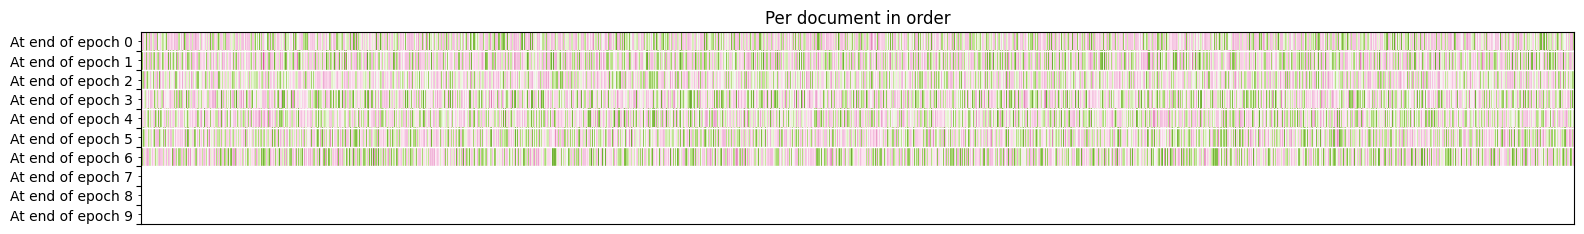

influence_incr_bins_dirac
[tensor([633992, 652883, 737094,  ..., 498017, 459970,   9171]), tensor([746899, 721344, 643533,  ..., 558162, 189743, 244202]), tensor([1004451,  995293,  871282,  ...,  515414,  477509,  299150]), tensor([864841, 693100, 720293,  ..., 307361, 498392, 415289]), tensor([1127730, 1023226,  581428,  ...,  274047,  185724,  249394]), tensor([ 787094, 1134426,  878795,  ...,  508827,  431972,   96603]), tensor([312763, 715145, 868104,  ..., 484340, 433338, 551042])]


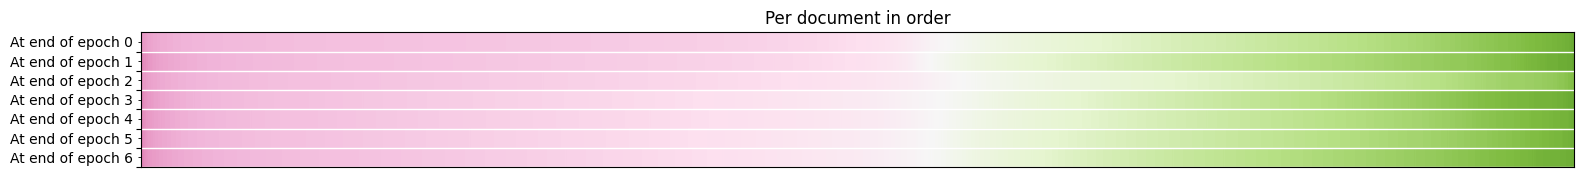

In [ ]:
import plotting
import matplotlib.pyplot as plt

# load influence data
for model_name, dataset_name in jobs:

    assert dataset_name in model_name


    RANDOM_CURRICULUM_NAME ="random.pt"


    influence_output_dir = os.path.join("./influence_mean_normalized", os.path.basename(model_name), "_".join([(os.path.basename(dataset_name) +"_"+f"train[0%:100%]")]*2))
    print(influence_output_dir)
    dataset = load_dataset(dataset_name)["train"]
    curriculum = util.get_curriculum(dataset_name, RANDOM_CURRICULUM_NAME)

    df = pd.DataFrame({int(result_checkpoint.replace("checkpoint-","")): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(influence_output_dir)})
    df.sort_index(axis=1)
    display(df)
    df = df.reindex(sorted(df.columns, reverse=False), axis=1)
    influence_cols = df.columns
    df["total"] = df.sum(axis=1)
    df[["text", "source","stage"]] = dataset.to_pandas()
    df["document_lenght"] = df["text"].str.split().str.len()
    plotting.plot_per_document_in_order(df[influence_cols],curriculum)
    plt.show()
    create_curricula(df, influence_cols, dataset_name, curriculum=RANDOM_CURRICULUM_NAME)



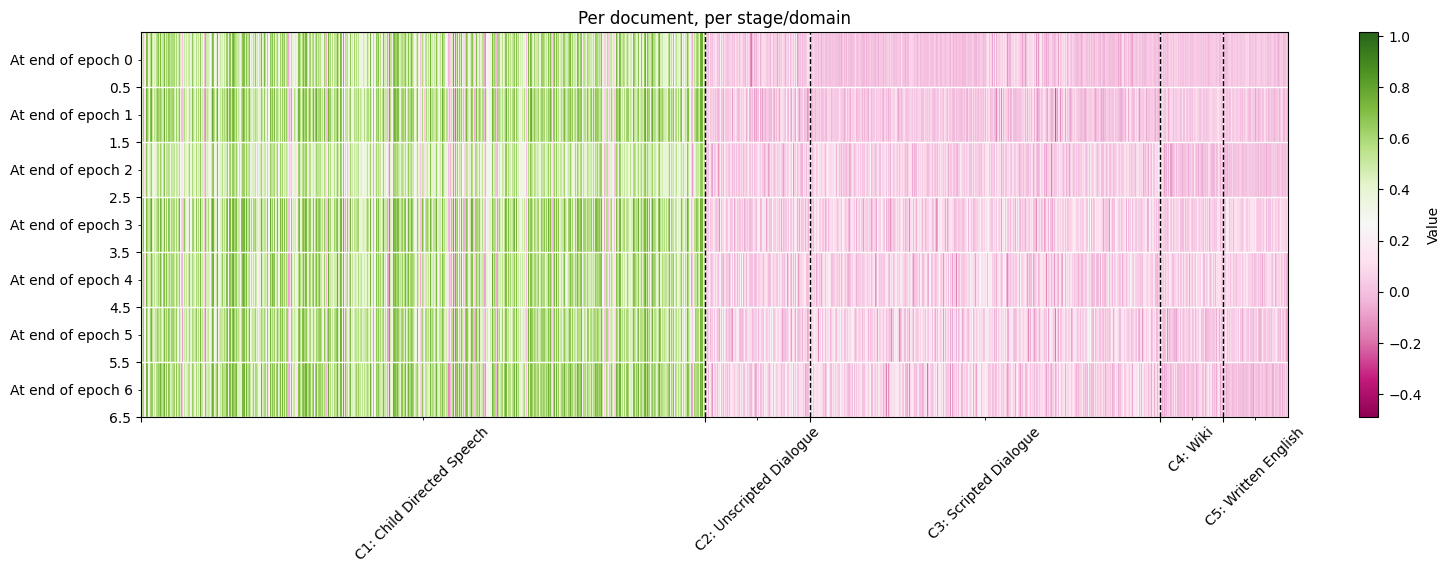

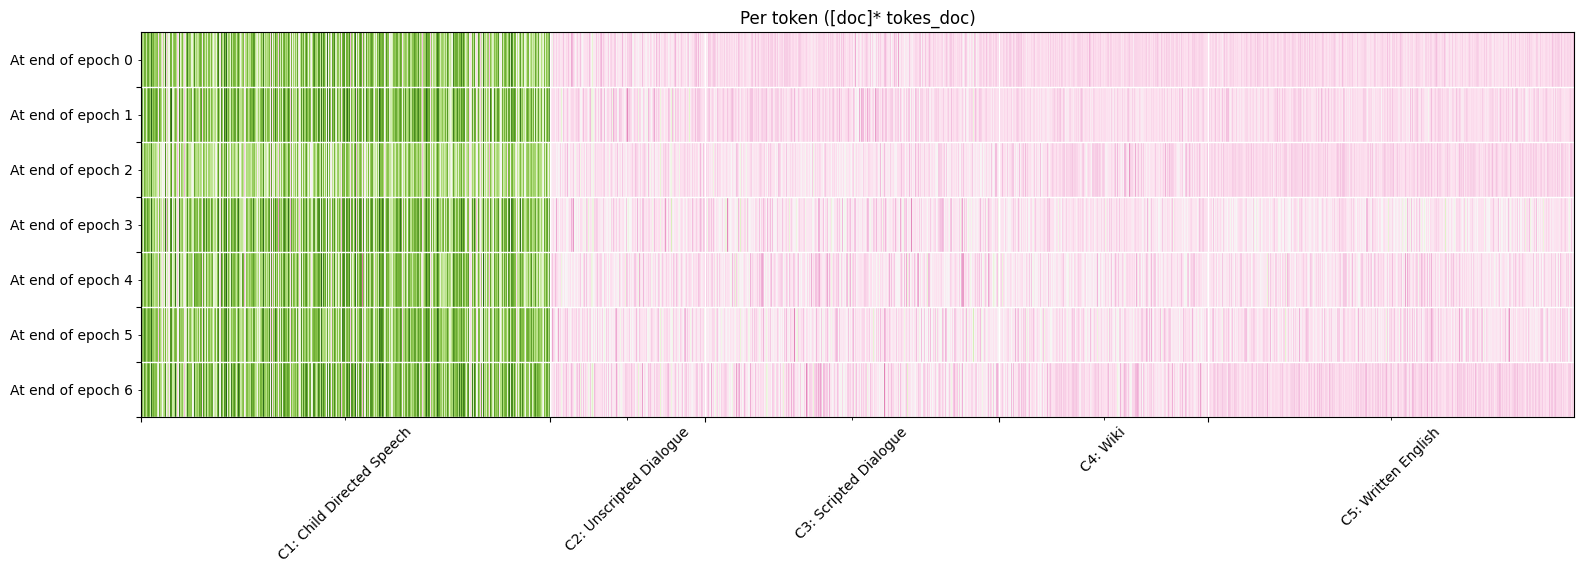

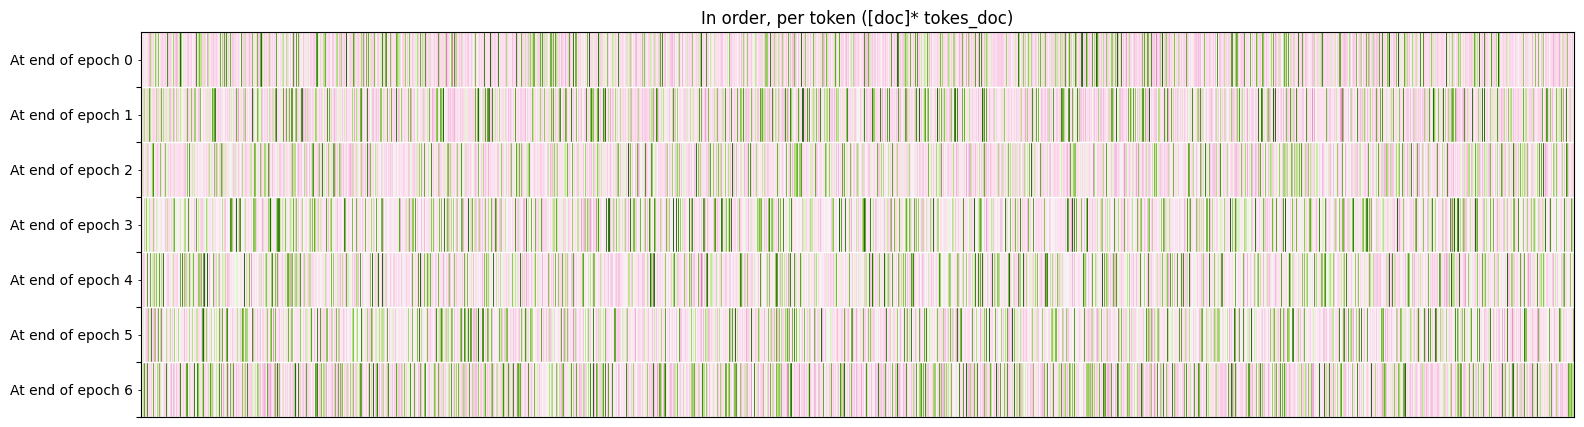

In [ ]:
import plotting
plotting.plot_per_document_per_stage(df[influence_cols.to_list() + ["stage"]], curriculum)
plotting.plot_per_token_per_stage(df[influence_cols.to_list() + ["stage","document_lenght"]], curriculum)
plotting.plot_per_token_in_order(df[influence_cols.to_list() + ["stage","document_lenght"]], curriculum)

In [ ]:
df

,1150,2300,4025,4600,4604,5750,5755,total,text,source,stage,document_lenght
0,0.644924,0.643681,0.554808,0.654035,0.612421,0.678787,0.614727,4.403382,*MOT:\tthere you go.,childes.train,C1: Child Directed Speech,4
1,0.300226,0.383101,0.293428,0.360522,0.321535,0.451455,0.500421,2.610688,*MOT:\twhich animals are going to go in my car...,childes.train,C1: Child Directed Speech,11
2,0.311873,0.498220,0.223567,0.477535,0.319431,0.370619,0.501018,2.702264,*MOT:\tand again although we asked for some fo...,childes.train,C1: Child Directed Speech,14
3,0.299575,0.457216,0.405790,0.370122,0.410824,0.425298,0.481614,2.850440,*CHI:\tand you put sunglasses on don't you?,childes.train,C1: Child Directed Speech,8
4,0.479425,0.466028,0.496276,0.481674,0.485573,0.601797,0.547553,3.558326,*INV:\tthere's loads.,childes.train,C1: Child Directed Speech,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1179009,0.010070,0.039062,0.000407,0.148507,0.024413,0.103225,0.003470,0.329155,"""Well, he has the saddle now, and I sincerely ...",gutenberg.train,C5: Written English,37
1179010,0.055716,0.083820,0.061032,0.065050,-0.019676,0.050847,0.040127,0.336917,"""Did you wake us up to tell us that?"" demanded...",gutenberg.train,C5: Written English,18
1179011,0.019248,0.053808,0.043449,0.196246,0.063751,-0.045050,0.000970,0.332422,"""She couldn't manage but one letter, I believe...",gutenberg.train,C5: Written English,14
1179012,0.001980,0.014706,0.006864,0.025123,0.069149,0.032576,0.085640,0.236037,"The moon he had so anxiously looked for, gave ...",gutenberg.train,C5: Written English,48


In [ ]:
hwrzsegrth

NameError: name 'hwrzsegrth' is not defined

In [ ]:
import torch
import os

In [ ]:
aa = sorted(os.listdir("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/"))[0:-1]

aa

['0_100000',
 '1000000_1100000',
 '100000_200000',
 '1100000_1200000',
 '200000_300000',
 '300000_400000',
 '400000_500000',
 '500000_600000',
 '600000_700000',
 '700000_800000',
 '800000_900000',
 '900000_1000000']

In [ ]:
len_dataset = len(load_dataset("loris3/babylm_2024_10m_curriculum")["train"])

EntryNotFoundError: 404 Client Error. (Request ID: Root=1-67e6ae6a-57f8f0ef1b6cbb75700aabe9;b47080f7-43f8-4588-8d2a-03c1e85a9b3b)

Entry Not Found for url: https://huggingface.co/datasets/loris3/babylm_2024_10m_curriculum/resolve/main/source_difficulty.

In [ ]:
torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",aa[0])).shape

torch.Size([100000, 1, 16384])

In [ ]:
torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",aa[0])).shape

torch.Size([100000, 1, 16384])

In [ ]:
import torch
chunk_b = torch.load("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/mean_normalized").flatten(0)
chunk_b.shape

torch.Size([16384])

In [ ]:
print(torch.nn.functional.normalize(torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",aa[0])).flatten(1)),)

KeyboardInterrupt: 

In [ ]:
torch.nn.functional.normalize(torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",aa[0])).flatten(1)).shape

torch.Size([100000, 16384])

In [ ]:
chunk_b

tensor([ 0.2789, -0.2261,  0.2499,  ...,  0.1101,  0.0932,  0.0942])

In [ ]:
torch.mv(torch.nn.functional.normalize(torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",aa[0])).flatten(1)), torch.nn.functional.normalize(chunk_b,dim=0))

tensor([0.6788, 0.4515, 0.3706,  ..., 0.3910, 0.3627, 0.1383])

In [ ]:
results = []

   
chunks_a = [torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",x)).flatten(1)for x in aa]

results.append([torch.mv(torch.nn.functional.normalize(chunk_a), chunk_b) for i, (chunk_a, _,_) in enumerate(chunks_a)] )


KeyboardInterrupt: 

In [ ]:
results

In [ ]:
result_post = torch.zeros((1,1,16384))
for x in aa:
    result_post += torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",x)).sum(axis=0)
result_post = result_post / len_dataset
result_post

tensor([[[ 1., -1.,  1.,  ...,  1.,  1.,  1.]]])

In [ ]:
result

In [ ]:
torch.nn.functional.normalize(torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",aa[0])).flatten(1))

tensor([[ 0.0062, -0.0028,  0.0100,  ..., -0.0027, -0.0009,  0.0094],
        [ 0.0077, -0.0026,  0.0049,  ...,  0.0028,  0.0085,  0.0147],
        [-0.0046, -0.0017,  0.0147,  ...,  0.0091,  0.0023, -0.0104],
        ...,
        [ 0.0137, -0.0079,  0.0071,  ...,  0.0071,  0.0024, -0.0015],
        [ 0.0066,  0.0030, -0.0087,  ...,  0.0010,  0.0006, -0.0084],
        [ 0.0042,  0.0019,  0.0031,  ..., -0.0038, -0.0099,  0.0028]])

In [ ]:
torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/","mean_normalized"))

tensor([[ 0.2789, -0.2261,  0.2499,  ...,  0.1101,  0.0932,  0.0942]])

In [ ]:
result_post

tensor([[[ 5387194.0000, -3698069.2500,  4824372.0000,  ...,
           1890993.3750,  1807849.6250,  1239554.1250]]])

In [ ]:
result_post = torch.nn.functional.normalize(result_post)

In [ ]:
result_post

tensor([[[ 1., -1.,  1.,  ...,  1.,  1.,  1.]]])

In [ ]:
result_post

tensor([[[ 1., -1.,  1.,  ...,  1.,  1.,  1.]]])

In [ ]:

(result / len_dataset).squeeze(0)

torch.Size([1, 16384])

In [ ]:
torch.allclose(result_post,result)

False

In [ ]:
mean_script = torch.load("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/mean_normalized").flatten(0)

In [ ]:
mean_script.shape

torch.Size([1, 16384])

In [ ]:
torch.allclose(mean_script, (result / len_dataset).squeeze(0))

True

In [ ]:
mean_script

NameError: name 'mean_script' is not defined

In [ ]:
chunk_b = torch.load(subtasks[0][0],weights_only=False).flatten(0) 

In [ ]:
mean_script.shape

torch.Size([1, 16384])

In [ ]:
torch.nn.functional.normalize(chunk_a, dim=1).shape

torch.Size([100000, 1, 16384])

In [ ]:
r = []
for x in aa:
    chunk_a = torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",x)).flatten(1)
    r.append(torch.mv(torch.nn.functional.normalize(chunk_a, dim=1), mean_script) )


In [ ]:
r = []
for x in aa:
    chunk_a = torch.load(os.path.join("gradients/16384/babylm_2024_10m_curriculum_llama_random/babylm_2024_10m_curriculum/train[0%:100%]/checkpoint-5750/",x)).flatten(1)
    
    r.append(torch.mv(torch.nn.functional.normalize(chunk_a, dim=1), mean_script) )

In [ ]:
r

[tensor([19.4528, 12.9379, 10.6213,  ..., 11.2045, 10.3934,  3.9634]),
 tensor([1.3559, 0.3636, 2.4648,  ..., 0.0000, 0.8190, 0.0989]),
 tensor([21.5279, 14.6800, 14.7795,  ..., 10.6351, 10.2281, 19.8631]),
 tensor([-0.1183, -0.4381,  0.6394,  ...,  1.4572, -1.2911,  0.9336]),
 tensor([12.7869, 13.0459, 18.5349,  ..., 16.2619, 11.0515, 20.7794]),
 tensor([21.1720, 17.6101, 10.4768,  ..., 18.7642, 14.4398, 18.0394]),
 tensor([16.9209, 11.9633, 10.7683,  ..., 14.9564, 11.6735, 19.9197]),
 tensor([ 7.3476, 17.3435, 14.6772,  ...,  0.7228,  5.3355,  1.1608]),
 tensor([ 2.1352,  7.4485, -1.0520,  ...,  0.1703,  2.9670,  0.2575]),
 tensor([-0.0936,  0.6104,  6.5346,  ...,  1.2255, -0.0173,  4.6180]),
 tensor([3.1012, 2.2112, 3.5301,  ..., 2.3492, 5.2123, 0.2657]),
 tensor([2.1756, 5.6401, 0.3559,  ..., 2.2955, 1.6521, 2.4731])]

In [ ]:
df = pd.DataFrame({int(result_checkpoint.replace("checkpoint-","")): torch.load(os.path.join(influence_output_dir,result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(influence_output_dir)})
df.sort_index(axis=1)

,4025,4600,4604,5750,5755
0,13.570839,18.895386,17.160353,19.452803,18.031574
1,7.177387,10.415656,9.009580,12.937877,14.678683
2,5.468560,13.796218,8.950621,10.621274,14.696187
3,9.925815,10.693005,11.511478,12.188253,14.127024
4,12.139126,13.915806,13.606003,17.246397,16.061188
...,...,...,...,...,...
1179009,0.009962,4.290448,0.684059,2.958246,0.101791
1179010,1.492870,1.879325,-0.551329,1.457184,1.177041
1179011,1.062776,5.669639,1.786345,-1.291063,0.028444
1179012,0.167887,0.725813,1.937580,0.933556,2.512049


In [ ]:
os.listdir(influence_output_dir)[2]

['checkpoint-5750',
 'checkpoint-4600',
 'checkpoint-4604',
 'checkpoint-5755',
 'checkpoint-4025']

In [ ]:
torch.load(os.path.join(influence_output_dir,os.listdir(influence_output_dir)[2])) / len(dataset)

tensor([[1.4555e-05, 7.6416e-06, 7.5916e-06,  ..., 1.5151e-06, 1.6434e-06,
         0.0000e+00]])

In [ ]:
# from baseline_curricula import validate_training_duration_limitation
# from itertools import product
# import config 

# [validate_training_duration_limitation(dataset_name, curriculum_name) for dataset_name, curriculum_name in product(config.datasets, config.curricula)]



KeyboardInterrupt: 

In [ ]:
curriculum

[tensor([462446, 809355, 368322,  ...,  39603, 402942, 413224]),
 tensor([1043188,   83287,    4986,  ...,  888024,  315089,  485807]),
 tensor([ 990716, 1173500,  715941,  ...,  540916,  768955,  349777]),
 tensor([ 999954,  149294,  739773,  ..., 1141682, 1045478,  626108]),
 tensor([ 359215,  277636, 1035301,  ...,    1674,  291775,  612176]),
 tensor([411963, 601356, 471672,  ..., 944379, 929044, 494661]),
 tensor([ 519346, 1125567,  929543,  ...,  416022,   28865,  410770]),
 tensor([ 862891,  345975, 1090811,  ...,  834544,  307552,  322251]),
 tensor([1119829,   24267, 1148313,  ...,   53795,  715191,   90101]),
 tensor([  69351,  642529,  740593,  ..., 1007246,  693065,  674208])]

In [ ]:






    # #############

    
    # if "equitoken" in dataset_name:
    #     lognorm_order = torch.repeat_interleave(lognorm_order,len(curriculum)//len(lognorm_order), dim=0)
        
    # plotting.plot_per_document_in_order(df, lognorm_order)
    # upload(lognorm_order, "lognorm")


    # lognorm_order_top_50_pct = get_order_top_n_pct(50,reweight_df(df, influence_cols, lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5)))
    # if "equitoken" in dataset_name:
    #     lognorm_order_top_50_pct = torch.repeat_interleave(lognorm_order_top_50_pct,len(curriculum)//len(lognorm_order_top_50_pct), dim=0)
    # plotting.plot_per_document_in_order(df, lognorm_order_top_50_pct)

    # upload(lognorm_order_top_50_pct, "lognorm_top_50_pct")



    # torch.manual_seed(42)
    # lognorm_order_top_50_pct_shuffled= torch.stack([row[torch.randperm(row.shape[0])] for row in lognorm_order_top_50_pct])
    # if "equitoken" in dataset_name:
    #     lognorm_order_top_50_pct_shuffled = torch.repeat_interleave(lognorm_order_top_50_pct_shuffled,len(curriculum)//len(lognorm_order_top_50_pct_shuffled), dim=0)
    # plotting.plot_per_document_in_order(df, lognorm_order_top_50_pct_shuffled)
    # upload(lognorm_order_top_50_pct_shuffled, "lognorm_top_50_pct_shuffled")


    # dirac_order = get_order_full(reweight_df(df, influence_cols, dirac_filter(len(influence_cols))))
    # if "equitoken" in dataset_name:
    #     dirac_order = torch.repeat_interleave(dirac_order,len(curriculum)//len(dirac_order), dim=0)
    # plotting.plot_per_document_in_order(df, dirac_order)
    # upload(dirac_order, "dirac")



    # get_order_positive_only = lambda df: [torch.tensor(df[checkpoint][df[checkpoint] >= 0].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols]
    # positive_only_order = get_order_positive_only(reweight_df(df, influence_cols, dirac_filter(len(influence_cols))))
    # if "equitoken" in dataset_name:
    #     positive_only_order = [positive_only_order[i] for i in torch.arange(0,len(positive_only_order)).repeat_interleave(len(curriculum)//len(positive_only_order))]
    # plotting.plot_per_document_in_order(df, positive_only_order)
    # upload(positive_only_order, "dirac_positive_only")



    # epochs = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), len(influence_cols))
    # epochs = [epoch.repeat(10) for epoch in epochs]
    # torch.manual_seed(42)
    # influential_examples_early_order = [epoch[torch.randperm(epoch.shape[0])] for epoch in epochs]
    # plotting.plot_per_document_in_order(df, influential_examples_early_order)
    # upload(influential_examples_early_order, "influential_examples_early")



    # halfs = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 2)
    # halfs = [half.repeat(10) for half in halfs]
    # torch.manual_seed(42)
    # influential_examples_first_half_order = list(torch.tensor_split(torch.cat([half[torch.randperm(len(half))] for half in halfs]), len(influence_cols)))
    # plotting.plot_per_document_in_order(df, influential_examples_first_half_order)
    # upload(influential_examples_first_half_order, "influential_examples_first_half")


    # halfs = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 2)
    # halfs = [half.repeat(10) for half in halfs]
    # torch.manual_seed(42)
    # influential_examples_first_half_order = list(torch.tensor_split(torch.cat([half[torch.randperm(len(half))] for half in halfs]), len(influence_cols)))
    # plotting.plot_per_document_in_order(df, influential_examples_first_half_order)
    # upload(influential_examples_first_half_order, "influential_examples_first_half")


    # thirds = torch.tensor_split(torch.tensor(df.sort_values(by="total", ascending=False)["total"].index.to_numpy()), 3)
    # thirds = [third.repeat(10) for third in thirds]
    # torch.manual_seed(42)
    # influential_examples_first_third_order = list(torch.tensor_split(torch.cat([third[torch.randperm(len(third))] for third in thirds]), len(influence_cols)))
    # plotting.plot_per_document_in_order(df, influential_examples_first_third_order)
    # upload(influential_examples_first_third_order, "influential_examples_first_third")



    # plotting.plot_per_document_in_order(df, influential_examples_sandwich)
    # upload(influential_examples_sandwich, "influential_examples_sandwich")


NameError: name 'lognorm_order' is not defined